In [1]:
%load_ext autoreload
%autoreload 2
import pickle
import numpy as np
from tqdm import tqdm
import torch
from torch.utils.data import DataLoader
import IPython.display as ipd
import pyximport
pyximport.install()
%load_ext Cython
import sigkernel as ksig
from utils.data import *
from model.generators import *

# Setup

In [2]:
hist_len = 32
sample_len = 64 #NOTE it includes the hist_len
noise_dim = 1
seq_dim = 3 # (gap, duration, pitch)
scale = 1.
dpitch_range = 12
stride = 800
folder = 'theorytab'

sigma = 1.0
kernel_type = 'truncated'
dyadic_order = 3
n_levels = 10
order = 1

batch_size = 64
activation = 'Tanh'
hidden_size = 64
n_layers = 1

epochs = 100
patience = 5

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
# with open(f'./data/dataframes/{folder}/melodies_beats_min_5_unique_max_range_24.pkl', 'rb') as f:
with open(f'./data/dataframes/{folder}/melodies_beats_min_5_unique_max_range_24_spec_cluster_12.pkl', 'rb') as f:
    songs = pickle.load(f)
len(songs)

7267

In [4]:
songs[0][1:]

('imai-asami', 'corpse-party---shangri-la', 'chorus_symbol_key.mid', 7)

In [5]:
cluster_labels = [item[-1] for item in songs]
unique_labels, counts = np.unique(cluster_labels, return_counts=True)
unique_labels.shape, counts

((12,),
 array([1166,  645,   60,  494,  722,  867,  512,  805,  634,  418,  204,
         740]))

In [6]:
# separate the dataframes by cluster
df_clusters = []
for i in range(unique_labels.shape[0]):
    df_clusters.append([item for item in songs if item[-1] == i])
    print(i, len(df_clusters[-1]))

0 1166
1 645
2 60
3 494
4 722
5 867
6 512
7 805
8 634
9 418
10 204
11 740


In [7]:
lens = [len(item[0]) for item in songs]
print('Max length:', max(lens))
stride = max(lens) + 1 # ensures no sampling from middle of song

Max length: 394


In [8]:
# gap_dur_dpitch_dfs = gap_duration_deltapitch_transform([item[0] for item in songs])
# clusters = [item[4] for item in songs]
# dataset = GapDurationDeltaPitchDataset(gap_dur_dpitch_dfs, sample_len=sample_len, scale=scale, stride=stride, clusters=clusters)

# cluster_idx = 0
# gap_dur_dpitch_dfs = gap_duration_deltapitch_transform([item[0] for item in df_clusters[cluster_idx]])

gap_dur_dpitch_dfs = gap_duration_deltapitch_transform([item[0] for item in songs])

dataset = GapDurationDeltaPitchDataset(gap_dur_dpitch_dfs, sample_len=sample_len, scale=scale, stride=stride)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=True)
len(dataset), len(dataloader)

(2273, 35)

In [9]:
if kernel_type == 'truncated':
    static_kernel = ksig.static.kernels.RationalQuadraticKernel(sigma=sigma)
    kernel = ksig.kernels.SignatureKernel(n_levels=n_levels, order=order, normalization=0, static_kernel=static_kernel, device_ids=None)
elif kernel_type == 'pde':
    static_kernel = ksig.sigkernelpde.RationalQuadraticKernel(sigma=sigma, alpha=1.0)
    kernel = ksig.sigkernelpde.SigKernelPDE(static_kernel, dyadic_order)

In [10]:
# generator = LSTMgate(noise_dim, seq_dim, sample_len, hidden_size, n_layers, activation)
# generator = LSTMinc(noise_dim, seq_dim, sample_len, dpitch_range, scale, hidden_size, n_layers, activation)
generator = LSTMinc_v2(noise_dim, seq_dim, sample_len, dpitch_range, scale, hidden_size, n_layers, activation)
generator = generator.cuda()
optimizer = torch.optim.Adam(generator.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=patience, factor=0.5, verbose=True)

# Training

In [11]:
for epoch in range(epochs):
    losses = []
    for batch_num, items in enumerate(tqdm(dataloader)):
        # X, title, cluster = items
        # cluster = cluster.to(device).unsqueeze(-1)
        X, title = items

        X = X.to(device)
        X_rect = batch_rectilinear_with_gap_transform(X[:, hist_len:, :])

        # For LSTMgate
        # noise = torch.randn(X.shape[0], X.shape[1]-1, noise_dim).to(device)
        # Y = generator(noise, cluster, X[:, :hist_len, :], X[:, hist_len:, :2])

        # For LSTMinc
        noise = torch.randn(X.shape[0], X.shape[1]-1, noise_dim).to(device)
        Y = generator(noise, X[:, :hist_len, :], X[:, hist_len:, :2])

        Y_rect = batch_rectilinear_with_gap_transform(Y[:, hist_len:, :])
        # print(output.shape, X.shape, X[:, :hist_len, :].shape)

        # compute loss
        optimizer.zero_grad()
        loss = ksig.tests.mmd_loss_no_compile(X_rect, Y_rect, kernel)
        losses.append(loss.item())

        # backpropagate and update weights
        loss.backward()
        optimizer.step()

    # log epoch loss and plot generated samples
    epoch_loss = np.average(losses) # average batch mmd for epoch
    scheduler.step(epoch_loss)
    print(f'Epoch {epoch+1}, loss: {epoch_loss}')
    if epoch_loss < 0.:
        sigma = sigma * 0.7
        static_kernel = ksig.static.kernels.RationalQuadraticKernel(sigma=sigma)
        kernel = ksig.kernels.SignatureKernel(n_levels=n_levels, order=order, normalization=0, static_kernel=static_kernel, device_ids=None)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, factor=0.5, verbose=True)
        print(f'New sigma: {sigma}')

  0%|          | 0/35 [00:00<?, ?it/s]

100%|██████████| 35/35 [00:21<00:00,  1.61it/s]


Epoch 1, loss: 154.50414559500558


100%|██████████| 35/35 [00:21<00:00,  1.62it/s]


Epoch 2, loss: 147.90500826154437


100%|██████████| 35/35 [00:21<00:00,  1.60it/s]


Epoch 3, loss: 124.08809858049665


100%|██████████| 35/35 [00:21<00:00,  1.62it/s]


Epoch 4, loss: 157.8638209751674


100%|██████████| 35/35 [00:21<00:00,  1.62it/s]


Epoch 5, loss: 78.7016871861049


100%|██████████| 35/35 [00:21<00:00,  1.62it/s]


Epoch 6, loss: 133.75665610177177


100%|██████████| 35/35 [00:21<00:00,  1.62it/s]


Epoch 7, loss: 148.10140707833426


100%|██████████| 35/35 [00:21<00:00,  1.62it/s]


Epoch 8, loss: 118.88375614711217


100%|██████████| 35/35 [00:21<00:00,  1.62it/s]


Epoch 9, loss: 105.33686174665179


100%|██████████| 35/35 [00:21<00:00,  1.62it/s]


Epoch 10, loss: 150.07268480573381


100%|██████████| 35/35 [00:21<00:00,  1.62it/s]


Epoch 00011: reducing learning rate of group 0 to 5.0000e-04.
Epoch 11, loss: 259.3283621651786


100%|██████████| 35/35 [00:21<00:00,  1.62it/s]


Epoch 12, loss: 111.06807076590401


100%|██████████| 35/35 [00:21<00:00,  1.62it/s]


Epoch 13, loss: 116.27383706229074


100%|██████████| 35/35 [00:21<00:00,  1.62it/s]


Epoch 14, loss: 75.4861827305385


100%|██████████| 35/35 [00:21<00:00,  1.62it/s]


Epoch 15, loss: 101.44219294956753


100%|██████████| 35/35 [00:21<00:00,  1.62it/s]


Epoch 16, loss: 71.67815464564733


100%|██████████| 35/35 [00:21<00:00,  1.62it/s]


Epoch 17, loss: 71.5559805733817


100%|██████████| 35/35 [00:21<00:00,  1.62it/s]


Epoch 18, loss: 92.08327287946429


100%|██████████| 35/35 [00:21<00:00,  1.60it/s]


Epoch 19, loss: 320.8596590314593


100%|██████████| 35/35 [00:21<00:00,  1.60it/s]


Epoch 20, loss: 84.24453909737723


100%|██████████| 35/35 [00:21<00:00,  1.60it/s]


Epoch 21, loss: 287.4547845023019


100%|██████████| 35/35 [00:21<00:00,  1.60it/s]


Epoch 22, loss: 279.957765851702


 57%|█████▋    | 20/35 [00:12<00:09,  1.55it/s]


KeyboardInterrupt: 

In [ ]:
# torch.save(generator.state_dict(), f'./data/weights/gapdurdpitch_{noise_dim}z_{sample_len}l_{hist_len}h_{key}_{n_levels}m_{order}o_{hidden_size}u_{n_layers}lstm.pt')

# Evaluation

In [ ]:
# generator.load_state_dict(torch.load(f'./data/weights/gapdurdpitch_{noise_dim}z_{sample_len}l_{hist_len}h_{key}_{n_levels}m_{order}o_{hidden_size}u_{n_layers}lstm.pt'))

### Sample and play MIDI

In [12]:
X_titles = []
for arg in title:
    X_titles.append((songs[arg.item()][1], songs[arg.item()][2], songs[arg.item()][3]))
start_pitch = 60
X[:,:,-1] /= scale
Y[:,:,-1] /= scale
X_dfs = batch_gap_duration_pitch_to_df(X, start_pitch=start_pitch)
Y_dfs = batch_gap_duration_pitch_to_df(Y, start_pitch=start_pitch)

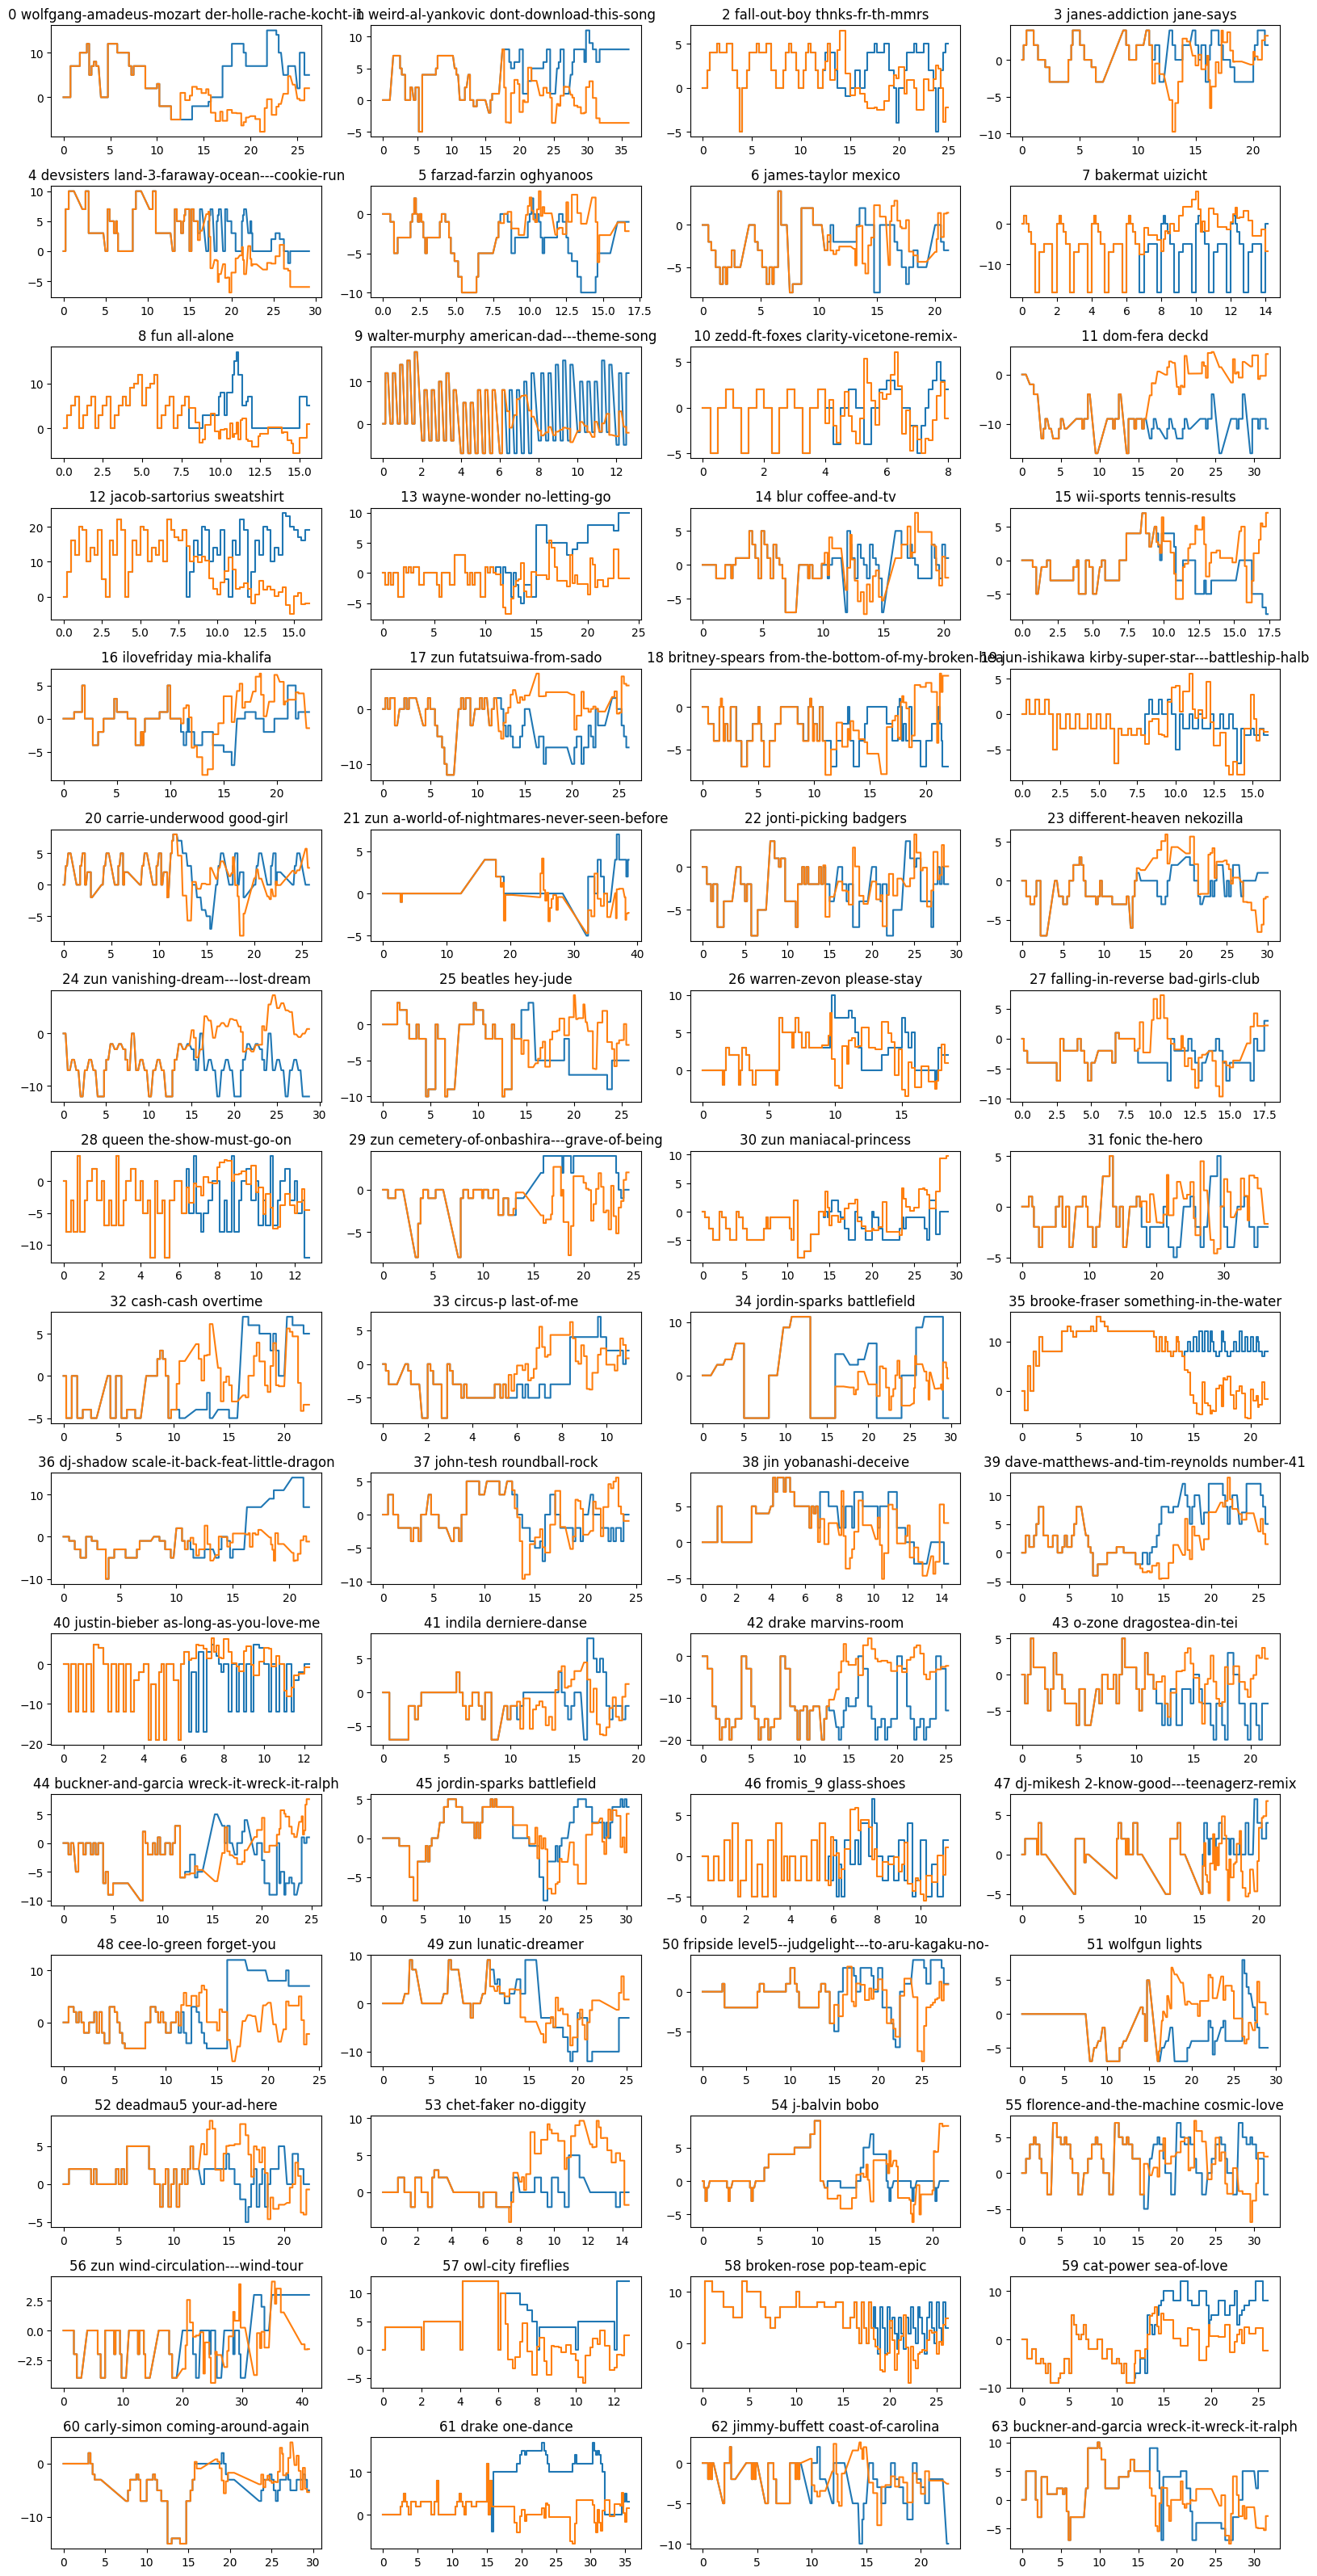

In [13]:
np_X_rect = batch_rectilinear_with_gap_transform(X).cpu().numpy()
np_Y_rect = batch_rectilinear_with_gap_transform(Y).detach().cpu().numpy()
fig, ax = plt.subplots(batch_size//4, 4, figsize=(16, batch_size//2))
for i in range(batch_size//4):
    for j in range(4):
        if batch_size//4 == 1:
            ax[j].plot(np_X_rect[j,:,0], np_X_rect[j,:,1]/scale)
            ax[j].plot(np_Y_rect[j,:,0], np_Y_rect[j,:,1]/scale)
            ax[j].set_title((f'{j} {X_titles[j][0]} {X_titles[j][1]}')[:50])
        else:
            ax[i, j].plot(np_X_rect[i*4+j,:,0], np_X_rect[i*4+j,:,1]/scale)
            ax[i, j].plot(np_Y_rect[i*4+j,:,0], np_Y_rect[i*4+j,:,1]/scale)
            ax[i, j].set_title((f'{i*4+j} {X_titles[i*4+j][0]} {X_titles[i*4+j][1]}')[:50])
plt.tight_layout()

In [24]:
sample_idx = 48
print(X_titles[sample_idx])

('cee-lo-green', 'forget-you', 'verse_symbol_key.mid')


In [25]:
input_midi = df_to_midi(X_dfs[sample_idx])
output_midi = df_to_midi(Y_dfs[sample_idx])

In [26]:
pd.merge(X_dfs[sample_idx][['Start', 'End', 'Pitch']], Y_dfs[sample_idx][['Pitch']], left_index=True, right_index=True)

Start    End  Pitch_x  Pitch_y
0    0.00   0.50     60.0     60.0
1    0.50   1.00     63.0     63.0
2    1.00   1.25     62.0     62.0
3    1.25   1.50     60.0     60.0
4    1.50   1.75     62.0     62.0
..    ...    ...      ...      ...
59  22.00  23.00     67.0     63.0
60  23.00  23.25     67.0     65.0
61  23.25  23.50     67.0     60.0
62  23.50  23.75     67.0     55.0
63  23.75  24.00     67.0     57.0

[64 rows x 4 columns]

In [27]:
fs=44100
audio_data = input_midi.fluidsynth(fs=fs, sf2_path='./data/soundfonts/Steinway_Grand_Piano_1.2.sf2')
ipd.Audio(audio_data, rate=fs)

In [28]:
fs=44100
audio_data = output_midi.fluidsynth(fs=fs, sf2_path='./data/soundfonts/Steinway_Grand_Piano_1.2.sf2')
ipd.Audio(audio_data, rate=fs)

### Evaluate note within key percentages

In [ ]:
Xs = []
Ys = []
for item in dataloader:
    X, title = item
    Xs.append(X)
    X = X.to(device)
    X_rect = batch_rectilinear_with_gap_transform(X[:, hist_len:, :])

    noise = torch.randn(X.shape[0], X.shape[1]-1, noise_dim).to(device)
    Y = generator(noise, X[:, :hist_len, :], X[:, hist_len:, :2])
    Ys.append(Y.detach().cpu())
    Y_rect = batch_rectilinear_with_gap_transform(Y[:, hist_len:, :])

Xs = torch.cat(Xs, dim=0)
Ys = torch.cat(Ys, dim=0)
print(Xs.shape, Ys.shape)
all_X_dfs = batch_gap_duration_pitch_to_df(Xs, start_pitch=start_pitch)
all_Y_dfs = batch_gap_duration_pitch_to_df(Ys, start_pitch=start_pitch)

torch.Size([320, 64, 3]) torch.Size([320, 64, 3])


In [ ]:
key_to_note = {0: 'C', 1: 'C#', 2: 'D', 3: 'D#', 4: 'E', 5: 'F', 6: 'F#', 7: 'G', 8: 'G#', 9: 'A', 10: 'A#', 11: 'B'}
key_notes = []
for i in range(12):
    key_notes.append(get_notes_from_major_scale(i))

In [ ]:
# check percentage of notes in C major scale
X_key_percentages = {0: [], 1: [], 2: [], 3: [], 4: [], 5: [], 6: [], 7: [], 8: [], 9: [], 10: [], 11: []}
Y_key_percentages = {0: [], 1: [], 2: [], 3: [], 4: [], 5: [], 6: [], 7: [], 8: [], 9: [], 10: [], 11: []}
for df in all_X_dfs:
    for i in range(len(key_notes)):
        percentage = len([note for note in df['Pitch'].values if note in key_notes[i]]) / len(df['Pitch'].values)
        X_key_percentages[i].append(percentage)
for df in all_Y_dfs:
    for i in range(len(key_notes)):
        percentage = len([note for note in df['Pitch'].values if note in key_notes[i]]) / len(df['Pitch'].values)
        Y_key_percentages[i].append(percentage)

Key: C
Mean percentage of notes in key C: 0.480078125
Mean percentage of notes in key C#: 0.8767578125
Mean percentage of notes in key D: 0.184228515625
Mean percentage of notes in key D#: 0.9109375
Mean percentage of notes in key E: 0.350537109375
Mean percentage of notes in key F: 0.66865234375
Mean percentage of notes in key F#: 0.62392578125
Mean percentage of notes in key G: 0.392578125
Mean percentage of notes in key G#: 0.93955078125
Mean percentage of notes in key A: 0.27353515625
Mean percentage of notes in key A#: 0.7619140625
Mean percentage of notes in key B: 0.5373046875


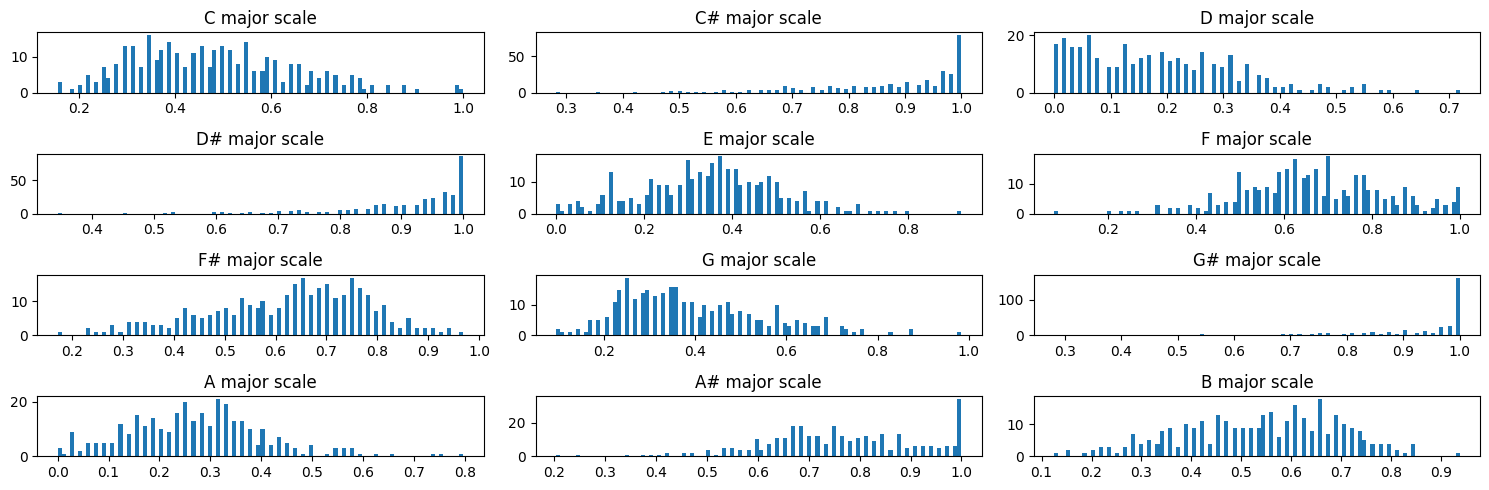

In [ ]:
fig, ax = plt.subplots(4, 3, figsize=(15, 5))
print(f'Key: {key_to_note[start_pitch % 12]}')
for i in range(len(key_notes)):
    print(f'Mean percentage of notes in key {key_to_note[i]}: {np.mean(X_key_percentages[i])}')
    ax[i//3, i%3].hist(X_key_percentages[i], bins=100)
    ax[i//3, i%3].set_title(f'{key_to_note[i]} major scale')
plt.tight_layout()

Key: C
Mean percentage of notes in key C: 0.527685546875
Mean percentage of notes in key C#: 0.7373046875
Mean percentage of notes in key D: 0.365673828125
Mean percentage of notes in key D#: 0.753173828125
Mean percentage of notes in key E: 0.4466796875
Mean percentage of notes in key F: 0.638916015625
Mean percentage of notes in key F#: 0.59423828125
Mean percentage of notes in key G: 0.500537109375
Mean percentage of notes in key G#: 0.774609375
Mean percentage of notes in key A: 0.4240234375
Mean percentage of notes in key A#: 0.67919921875
Mean percentage of notes in key B: 0.557958984375


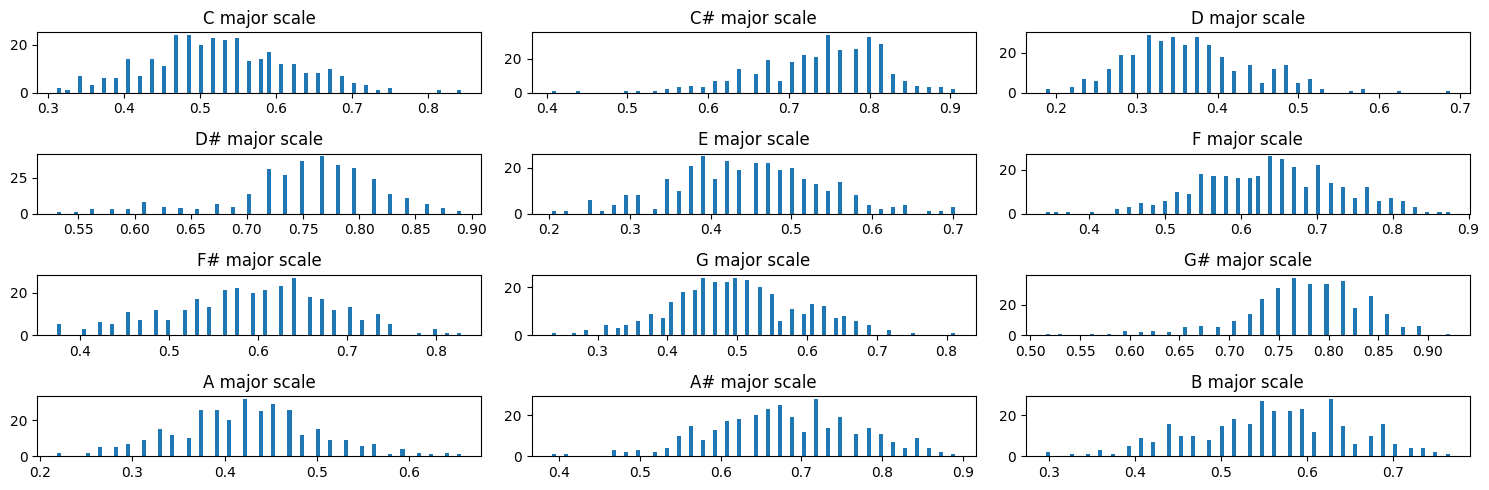

In [ ]:
fig, ax = plt.subplots(4, 3, figsize=(15, 5))
print(f'Key: {key_to_note[start_pitch % 12]}')
for i in range(len(key_notes)):
    print(f'Mean percentage of notes in key {key_to_note[i]}: {np.mean(Y_key_percentages[i])}')
    ax[i//3, i%3].hist(Y_key_percentages[i], bins=100)
    ax[i//3, i%3].set_title(f'{key_to_note[i]} major scale')
plt.tight_layout()